In [1]:
#pip install plotly

In [2]:
import glob
import sys
import os
import datetime
import pathlib
#---------------------
import numpy as np
import pandas as pd
#-----------------------
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.image as mpimp
import IPython.display as display
from PIL import Image
#mpl.rcParams['axes.grid']=False
#mpl.rcParams['figure,figsize']=(12,12)

from IPython import get_ipython

ipy=get_ipython()
if ipy is not None:
    pass
#------------------------
from plotly import graph_objs as go
from plotly.subplots import make_subplots
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow import feature_column
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,Dropout,MaxPooling2D
print(tf.__version__)
physical_devices=tf.config.list_physical_devices('CPU')
print("Num CPUs:",len(physical_devices))
print(tf.test.is_built_with_cuda())

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve,auc
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import re
sys.path.append('res')

2.8.0
Num CPUs: 1
True


In [3]:
mpl.rcParams.keys()

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
        

In [4]:
AUTOTUNE=tf.data.experimental.AUTOTUNE

In [5]:
import sys
data_dir='D:\downloads 1-22-2022\seg_train\seg_train'
data_dir=pathlib.Path(data_dir)
image_count=len(list(data_dir.glob('*/*.jpg')))
print(image_count)
CLASS_NAMES=np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES.sort()
print(CLASS_NAMES)
num_classes=len(CLASS_NAMES)
one=list(data_dir.glob('1/*'))

for image_path in one[:3]:
    display.display(Image.open(str(image_path)))
    


14034
['buildings' 'forest' 'glacier' 'mountain' 'sea' 'street']


In [6]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

labels = ['Buildings','Forest','Glacier','Mountain','sea','Street']
# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=labels, values = [2191, 2271, 2404, 2512, 2274, 2382], name="INTEL dataset"),
              1, 1)
# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name")

fig.update_layout(
    title_text="INTEL image Classification dataset overview",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Data', x=0.18, y=0.5, font_size=20, showarrow=False),
                 ])
fig.show()

In [7]:
#see: https://www.tensorflow.org/api_docs/python/tf/data/Dataset#list_files
#list_ds=tf.data.Dataset.list_files(str(data_dir/'*/*'))
#alternate best method
list_of_all_files=tf.io.gfile.glob(str(data_dir/'*/*'))
X_train,X_test=train_test_split(list_of_all_files,test_size=0.3, random_state=42)
train_file_dataset=tf.data.Dataset.from_tensor_slices(X_train)
test_file_dataset=tf.data.Dataset.from_tensor_slices(X_test)



Helper functions here

In [8]:
def get_label(file_path):
    #CONVERT THE PATH TO A LIST OF PATH COMPONENTS
    parts=tf.strings.split(file_path,os.path.sep)
    #THE SECOND TO LAST IS THE CLASS-DIRECTORY
    #Run this to understand what is going on: '1'==Class_names
    return parts[-2]== CLASS_NAMES
    #USE FOLLOWING TWO LINES WITH SparseCategoricalCrossEntropy (one hot encoded label)
    #Integer encode the label
    #return tf.argmax[one_hot]
def decode_img(img):
    #convert the compressed string to a 3D unint8 tensor
    img=tf.image.decode_jpeg(img,channels=3)
    #use convert_image_dtype to convert to floats in the [0,1] range
    img=tf.image.convert_image_dtype(img,tf.float32)
    #resisze the image to the desired size
    return tf.image.resize(img,[IMG_HEIGHT, IMG_WIDTH])
    #return img
    
def process_path(file_path):
    label=get_label(file_path)
    img=tf.io.read_file(file_path)
    img=decode_img(img)
    return img,label




In [9]:
IMG_HEIGHT=150
IMG_WIDTH=150
#set 'num_parallel_calls' so multiple images are loaded/processed in parallel
#see https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map
#use mapping to apply function to each element of the dataset
train_labeled_ds=train_file_dataset.map(process_path,num_parallel_calls=AUTOTUNE)
test_labeled_ds=test_file_dataset.map(process_path,num_parallel_calls=AUTOTUNE)

for image, label in train_labeled_ds.take(1):
    print("Image shape:",image.numpy().shape)
    print("Label:",label.numpy())

Image shape: (150, 150, 3)
Label: [False False False False  True False]


In [10]:
#First set some parameters
IMG_WIDTH,IMG_HEIGHT,NO_CH=image.numpy().shape
BATCH_SIZE=32
IMG_HEIGHT=150
IMG_WIDTH=150
STEPS_PER_EPOCH=np.ceil(len(X_train)/BATCH_SIZE)

BASIC PIPELINE METHODS FOR TRAINING

to train a model with this dataset you will want the data:
to be well shuffled. To be batched. Batches to be available as soon as possibel. These features ca be easily added using the tf data api

In [11]:
#helper function to setup dataset ready to feed
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
#this is a small dataset, only load it once and keep it in memory
#use '.cache(filename)' to cache preprocessing work for datasets that don't 
#fit in memory
    if cache:
         if isinstance(cache,str):
            ds=ds.cache(cache)
         else:
            ds=ds.cache()
    ds=ds.shuffle(buffer_size=shuffle_buffer_size)
    ds=ds.batch(BATCH_SIZE)
        #REPEAT FOREVER
    ds=ds.repeat()
        #'prefetch' lets the dataset fetch batches in the background while the model 
        #is trainig
    ds=ds.prefetch(buffer_size=AUTOTUNE)
    return ds
    

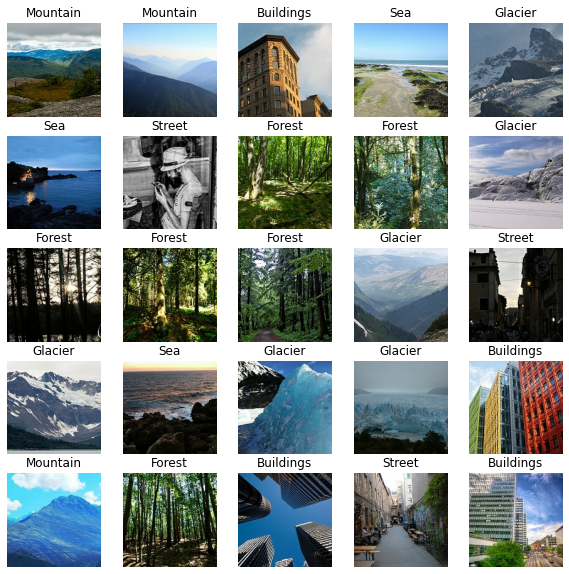

In [12]:
train_ds=prepare_for_training(train_labeled_ds)
test_ds=prepare_for_training(test_labeled_ds)
image_batch,label_batch=next(iter(train_ds))

def show_batch(image_batch,label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax=plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')
show_batch(image_batch.numpy(),label_batch.numpy())

Data Augmentation

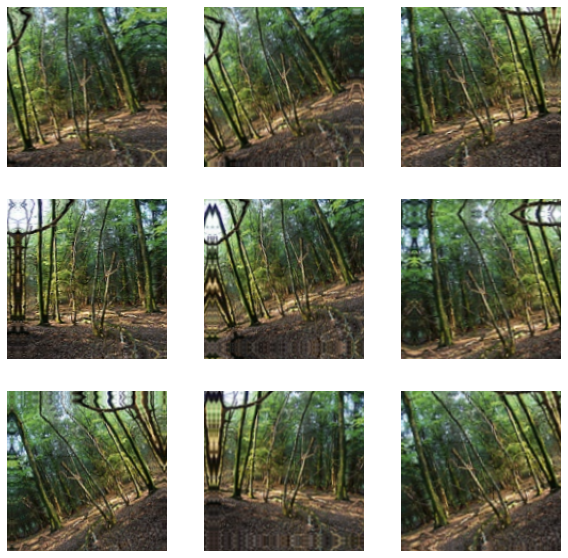

In [13]:
data_augmentation=keras.Sequential(
[
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                  input_shape=(IMG_HEIGHT,
                                                               IMG_WIDTH,
                                                               3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomTranslation(0.1,0.1),

]
)

plt.figure(figsize=(10,10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images=data_augmentation(images)
        ax=plt.subplot(3,3,i+1)
        plt.imshow(augmented_images[0].numpy())
        plt.axis("off")

# Model

In [14]:
model=Sequential([
    data_augmentation,
    #layers.eperimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(16,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(32,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(64,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
    
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [17]:
logdir="logs"
tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=logdir)

# Display model architechture

In [18]:
tf.keras.utils.plot_model(model=model,rankdir="LR",show_shapes=True)
model.summary()

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 75, 75, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        4640      
                        

In [ ]:
checkpointer=tf.keras.callbacks.ModelCheckpoint('checkpoint.j=h5',verbose=1,save_best_only=True)
callbacks=[
    tf.keras.callbacks.EarlyStopping(patience=5,monitor='val_loss')
    #tf.keras.callbacks.TensorBoard(log_dir='logs'),
]
epochs=30
history=model.fit(
        train_ds,
        steps_per_epoch=STEPS_PER_EPOCH,  
        epochs=epochs,
        validation_data=test_ds,
        validation_steps=STEPS_PER_EPOCH,
        callbacks=callbacks,
)

Epoch 1/30
307/307 [==============================] - 234s 754ms/step - loss: 1.2888 - accuracy: 0.4974 - val_loss: 0.9916 - val_accuracy: 0.6408
Epoch 2/30
307/307 [==============================] - 207s 676ms/step - loss: 1.0124 - accuracy: 0.6155 - val_loss: 0.9201 - val_accuracy: 0.6413
Epoch 3/30
307/307 [==============================] - 193s 630ms/step - loss: 0.8999 - accuracy: 0.6624 - val_loss: 0.8770 - val_accuracy: 0.6561
Epoch 4/30
307/307 [==============================] - 191s 623ms/step - loss: 0.8200 - accuracy: 0.6920 - val_loss: 0.8024 - val_accuracy: 0.6892
Epoch 5/30
307/307 [==============================] - 202s 658ms/step - loss: 0.7571 - accuracy: 0.7226 - val_loss: 0.6843 - val_accuracy: 0.7413
Epoch 6/30
307/307 [==============================] - 196s 640ms/step - loss: 0.7116 - accuracy: 0.7408 - val_loss: 0.7235 - val_accuracy: 0.7223
Epoch 7/30
307/307 [==============================] - 192s 626ms/step - loss: 0.6744 - accuracy: 0.7561 - val_loss: 0.6217 -

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']
epochs_range=epochs_range=history.epoch
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Training Accuracy')
plt.plot(epochs_range,val_acc,label='validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='Training loss')
plt.plot(epochs_range,val_loss,label='validation loss')
plt.legend(loc='upper right')
plt.title('Training and Validation loss')


# Evaluate model

In [ ]:
test_loss,test_acc=model.evaluate(test_ds.take(51),verbose=2)
print('\nTest accuracy:',test_acc)


# Use model: make predictions

In [ ]:
probability_model=tf.keras.Sequential([model,tf.keras.layers.Softmax()])

iterator=iter(test_ds)
tst_img,tst_labels=iterator.get_next()
predictions=probability_model.predict(tst_img)

predictions[0]
def plot_image(i, predictions_array,true_label,img):
  true_label,img= true_label, img
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img,cmap=plt.cm.binary)
  predicated_label=np.argmax(predictions_array)
  if predicated_label== true_label:
        color= 'blue'
  else:
        color= 'red'
  plt.xlabel("{} {:2.0f}% ({})".format(CLASS_NAMES[predicated_label],
                                       100*np.max(predictions_array),
                                       CLASS_NAMES[true_label]),
                                       color=color)

def plot_value_array(i, predictions_array,true_label):
    true_label=true_label
    plt.grid(False)
    plt.xticks(range(num_classes))
    plt.yticks([])
    thisplot=plt.bar(range(num_classes),predictions_array, color="#777777")
    plt.ylim([0,1])
    predicted_label=np.argmax(predictions_array)
    
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')
    
for i in range(15):
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plot_image(i,predictions[i],np.argmax(tst_labels[i]),tst_img[i])
    plt.subplot(1,2,2)
    plot_value_array(i,predictions[i],np.argmax(tst_labels[i]))
    plt.show()

In [ ]:
tf.math.confusion_matrix(
    labels,
    predictions,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
)

In [ ]:
logdir="logs"
tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=logdir)

# Deploy model

In [ ]:
probability_model.summary()
#calling save('my_model') creates a savemodel folder my_model
probability_model.save("my_lastt_model")
#convert the model
converter=tf.lite.TFLiteConverter.from_saved_model("my_model")#path to saved model directory
tflite_model=converter.convert()

#save the model
with open('latestmodel.tflite', 'wb') as f:
    f.write(tflite_model)
